# Sentiment Analysis with Python
This is an example of training a sentiment classifier with Python. 

The aims of this hands-on experiment are to present:
- the basics of data analysis
- how to pre-process a dataset and why it is important
- the (very) basics of supervised machine learning
- analysis of a classifier's results

We will use the [Women's E-commerce Clothing Review](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews) dataset with their rating scores.

In [2]:
#loading some libraries
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, accuracy_score
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#download and read the dataset
dataset = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")

In [4]:
#try to print only the column for reviews and only the column for sentiments
dataset

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


## Data Analysis

In [5]:
#playing with graphs
plot_size = plt.rcParams["figure.figsize"] 
plot_size[0] = 10
plot_size[1] = 10
plt.rcParams["figure.figsize"] = plot_size 

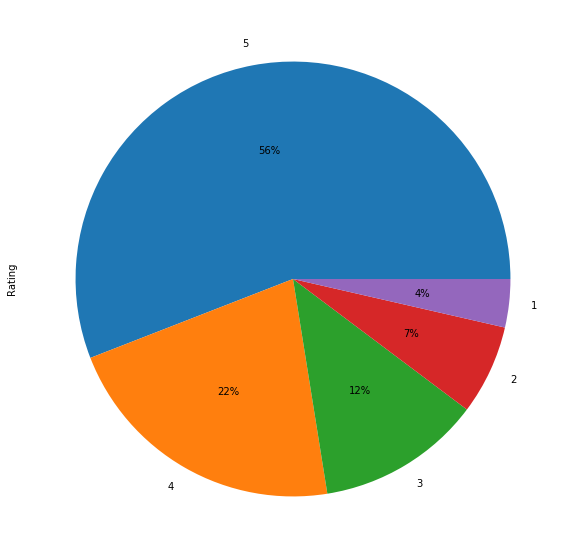

In [6]:
#ploting the distribution of ratings
dataset['Rating'].value_counts().plot(kind='pie', autopct='%1.0f%%')

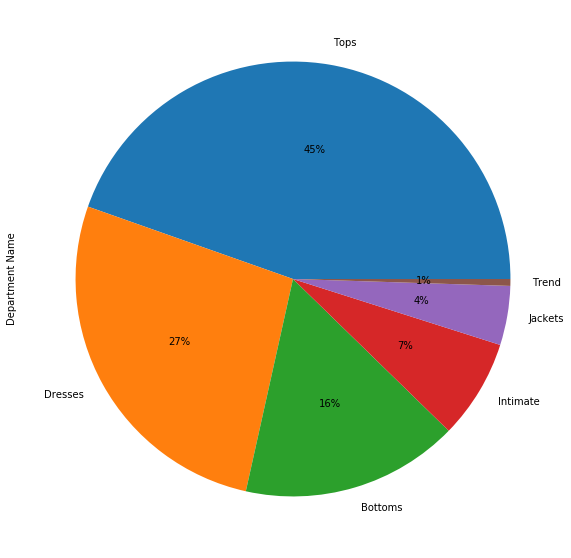

In [7]:
#ploting the distribution of departments
dataset['Department Name'].value_counts().plot(kind='pie', autopct='%1.0f%%')

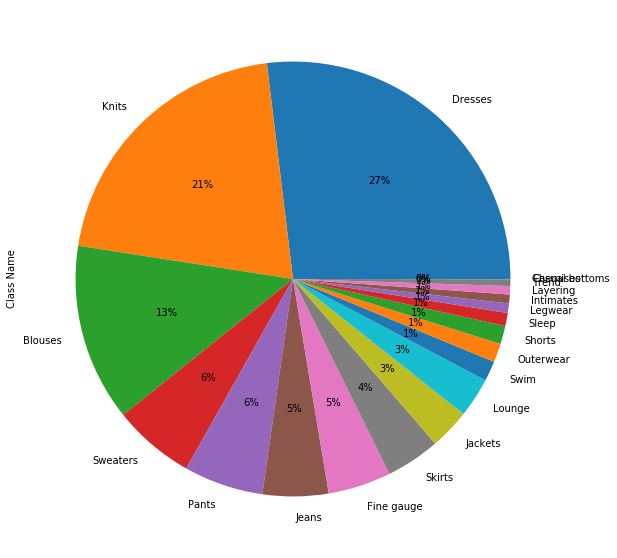

In [8]:
#ploting the distribution of classes
dataset['Class Name'].value_counts().plot(kind='pie', autopct='%1.0f%%')

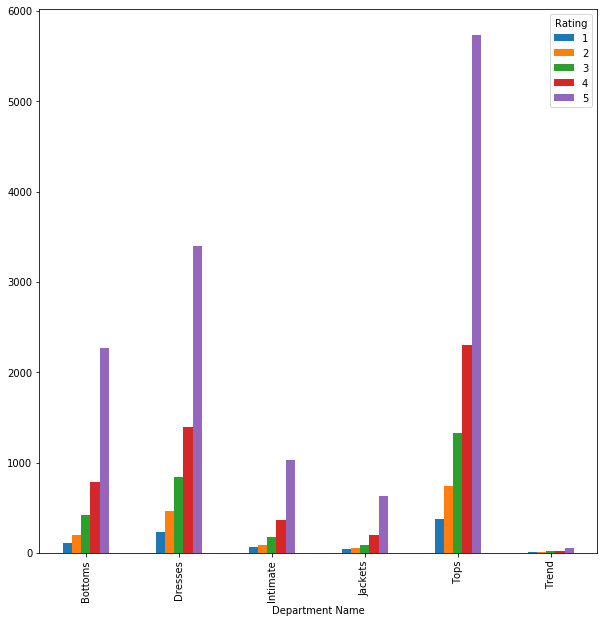

In [9]:
#why this graph can be misleading? 
clothes_sentiment = dataset.groupby(['Department Name', 'Rating'])['Rating'].count().unstack()
clothes_sentiment.plot(kind='bar')

** Number of each rating per department **
Rating             1    2     3     4     5
Department Name                            
Bottoms          115  205   421   785  2273
Dresses          228  461   838  1395  3397
Intimate          63   90   178   371  1033
Jackets           49   60    91   201   631
Tops             376  738  1324  2299  5731
Trend             11   11    19    26    52
** Sum of ratings per deparment **
Department Name
Bottoms      3799
Dresses      6319
Intimate     1735
Jackets      1032
Tops        10468
Trend         119
dtype: int64
** Percentage of each rating per department **
Rating                  1         2         3         4         5
Department Name                                                  
Bottoms          0.030271  0.053962  0.110819  0.206633  0.598315
Dresses          0.036082  0.072955  0.132616  0.220763  0.537585
Intimate         0.036311  0.051873  0.102594  0.213833  0.595389
Jackets          0.047481  0.058140  0.088178  0.194767 

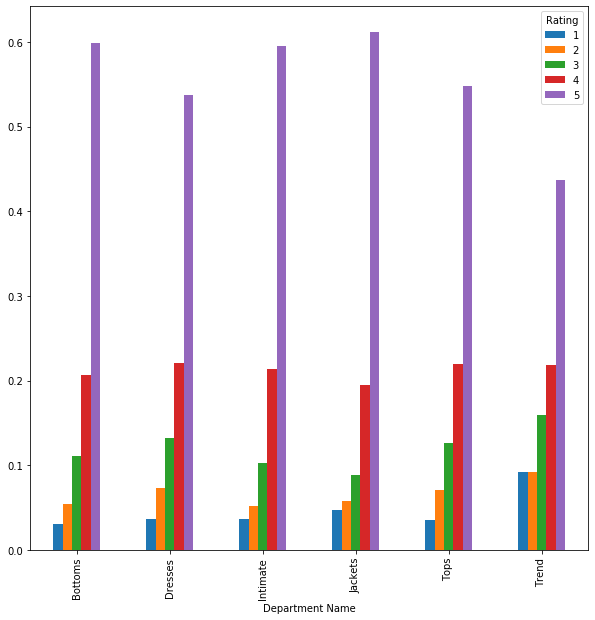

In [10]:
##Analysing according to the counts of ratings
clothes_sentiment_count = dataset.groupby(['Department Name', 'Rating'])['Rating'].count().unstack()
print("** Number of each rating per department **")
print(clothes_sentiment_count)
#sum per deparment
print("** Sum of ratings per deparment **")
dept_sum = clothes_sentiment_count.sum(axis=1)
print(dept_sum)
#print(clothes_sentiment_sum)
#percentage
clothes_sentiment_perc = (clothes_sentiment_count.transpose()/dept_sum).transpose()
print("** Percentage of each rating per department **")
print(clothes_sentiment_perc)
clothes_sentiment_perc.plot(kind='bar')

## Pre-processing

In [11]:
#analysing the text: any ideas of potential problems? 
dataset['Review Text'][2]

'I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c'

In [12]:
#transforming the review column into an array of reviews
features = np.array(dataset['Review Text'])
features

array(['Absolutely wonderful - silky and sexy and comfortable',
       'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.',
       'I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c',
       ...,
       "This fit well, but the top was very see through. this never would have worked for me. i

In [13]:
#creating the vector with the labels (transforming categorical values into numbers)
#positive = 1
#negative = 0
labels = [int(l) for l in dataset['Rating']]
labels

[4,
 5,
 3,
 5,
 5,
 2,
 5,
 4,
 5,
 5,
 3,
 5,
 5,
 5,
 3,
 4,
 3,
 5,
 5,
 5,
 4,
 4,
 2,
 3,
 5,
 3,
 2,
 4,
 5,
 5,
 5,
 5,
 5,
 2,
 5,
 4,
 4,
 5,
 5,
 5,
 4,
 5,
 5,
 4,
 5,
 4,
 5,
 5,
 5,
 5,
 4,
 5,
 3,
 5,
 4,
 5,
 2,
 3,
 4,
 4,
 5,
 1,
 5,
 5,
 5,
 4,
 4,
 5,
 2,
 3,
 4,
 2,
 5,
 4,
 5,
 5,
 4,
 2,
 5,
 4,
 5,
 5,
 5,
 5,
 3,
 1,
 4,
 4,
 2,
 4,
 4,
 5,
 5,
 5,
 4,
 5,
 1,
 1,
 5,
 3,
 4,
 4,
 5,
 2,
 2,
 5,
 4,
 4,
 5,
 5,
 1,
 3,
 5,
 5,
 2,
 4,
 4,
 5,
 2,
 5,
 5,
 5,
 5,
 5,
 3,
 3,
 4,
 5,
 4,
 5,
 4,
 3,
 4,
 5,
 5,
 4,
 4,
 4,
 4,
 5,
 5,
 4,
 5,
 5,
 3,
 3,
 5,
 5,
 5,
 5,
 5,
 4,
 3,
 3,
 3,
 5,
 5,
 3,
 4,
 4,
 4,
 1,
 4,
 5,
 4,
 3,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 5,
 4,
 5,
 5,
 2,
 5,
 5,
 4,
 5,
 4,
 2,
 2,
 4,
 5,
 4,
 4,
 4,
 2,
 5,
 5,
 3,
 5,
 5,
 5,
 5,
 3,
 3,
 5,
 3,
 5,
 4,
 3,
 5,
 4,
 5,
 1,
 5,
 4,
 4,
 5,
 1,
 5,
 2,
 5,
 5,
 5,
 4,
 5,
 5,
 5,
 4,
 5,
 5,
 4,
 4,
 4,
 5,
 5,
 2,
 5,
 5,
 5,
 5,
 2,
 5,
 3,
 4,
 1,
 5,
 4,
 3,
 5,
 3,
 4,
 5,
 4,


In [14]:
#splitting the data into training, validation and test sets
#training = data used to train the classifiers
#validation = data used to tune the classifiers' parameters (it will make more sense later)
#test = data used to test the classifiers
raw_train, raw_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)
raw_train, raw_val, y_train, y_val = train_test_split(raw_train, y_train, train_size = 0.8)

In [15]:
#Pre-processing the reviews
#normalise words, remove punctuation, remove extra spaces, etc
def pre_proc(features):
    processed_features = []
    for sentence in range(0, len(features)):
        # Remove all tags (like <br />)
        processed_feature = re.sub(r'<.*?>', ' ', str(features[sentence]))

        #Remove all special characters
        processed_feature = re.sub(r'[^a-zA-Z0-9]', ' ', processed_feature)

        # Substituting multiple spaces with single space
        processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

        # Removing prefixed 'b'
        processed_feature = re.sub(r'^b\s+', '', processed_feature)

        # Converting to Lowercase
        processed_feature = processed_feature.lower()

        processed_features.append(processed_feature)
    return processed_features

In [16]:
#apply pre_proc() function to all data splits
proc_train = pre_proc(raw_train)
proc_val = pre_proc(raw_val)
proc_test = pre_proc(raw_test)

In [17]:
print("Original: %s" % raw_train[2])
print("Pre-processed: %s" % proc_train[2])

Original: This casual top is adorable! a great top for jeans, linen pants or shorts! it would be cute with skirts too. 
i love the heavy feel of the fabric. too many fabrics today are thin and/or clingy. this is soft, but is substantial. it works well on my body-type. tall, thin, without much figure. it's not cheap, but something i'll likely keep for a few years.
Pre-processed: this casual top is adorable a great top for jeans linen pants or shorts it would be cute with skirts too i love the heavy feel of the fabric too many fabrics today are thin and or clingy this is soft but is substantial it works well on my body type tall thin without much figure it s not cheap but something i ll likely keep for a few years 


## Feature Extraction
We will use bag-of-words as features for training our classifiers. In a bag-of-words approach, an algorithm counts the number of times a word appear in a document. Each word in the entire collection of documents (corpus) became a feature in the feature vector, which results in a sparse vector.

Instead of count the "number of times" a word appear in a document, we can also use a binary approach (whether or not a word a appear in a document). Any other ideas? 

In [18]:
#We are using a binary bag-of-words approach: if a word appears in a document it will receive 1 (0 otherwise)
cv = CountVectorizer(binary=True)
cv.fit(proc_train)

#check the features outputted below
#each possible word in our pre-processed vector became a feature
#can we do better? 
print("Vocabulary size: %d" % len(cv.get_feature_names()))
print("Words:")
print(cv.get_feature_names())

Vocabulary size: 11690
Words:
['00', '00p', '02', '03', '0in', '0p', '0petite', '0r', '10', '100', '100lb', '100lbs', '101', '102', '102lbs', '103', '103lb', '103lbs', '104', '104lbs', '105', '105lbs', '106', '106lbs', '107', '107lb', '107lbs', '108', '108lbs', '109', '109lbs', '10l', '10lbs', '10mths', '10p', '10s', '11', '110', '110lb', '110lbs', '111', '111lbs', '112', '112lbs', '113', '113lbs', '114', '114lb', '114lbs', '115', '115ish', '115lbs', '116', '116bs', '116ibs', '116lb', '116lbs', '117', '117lbs', '118', '118lb', '118lbs', '119', '11in', '11inches', '12', '120', '120lb', '120lbs', '121', '122', '122lb', '122lbs', '123', '123lb', '123lbs', '124', '124lbs', '125', '125b', '125ish', '125lb', '125lbs', '126', '126lbs', '127', '127lb', '127lbs', '128', '128b', '128lb', '128lbs', '129', '129lbs', '12p', '13', '130', '130b', '130lb', '130lbs', '132', '132lbs', '133', '133lbs', '134', '134lb', '134lbs', '135', '135lb', '135lbs', '136', '136lbs', '137', '138', '138lbs', '139', '14

In [19]:
#apply the model to all data splits
#can you think of any problems? 
X_train = cv.transform(proc_train)
X_val = cv.transform(proc_val)
X_test = cv.transform(proc_test)

In [20]:
print(X_train)

  (0, 1349)	1
  (0, 1768)	1
  (0, 3388)	1
  (0, 4124)	1
  (0, 5282)	1
  (0, 5514)	1
  (0, 5727)	1
  (0, 5944)	1
  (0, 6002)	1
  (0, 6103)	1
  (0, 6207)	1
  (0, 6360)	1
  (0, 6890)	1
  (0, 7036)	1
  (0, 7443)	1
  (0, 8674)	1
  (0, 8892)	1
  (0, 8942)	1
  (0, 9267)	1
  (0, 10335)	1
  (0, 10340)	1
  (0, 10393)	1
  (0, 10499)	1
  (0, 10534)	1
  (0, 11280)	1
  :	:
  (15029, 898)	1
  (15029, 1016)	1
  (15029, 2314)	1
  (15029, 2353)	1
  (15029, 2425)	1
  (15029, 4024)	1
  (15029, 4548)	1
  (15029, 4714)	1
  (15029, 5514)	1
  (15029, 6103)	1
  (15029, 6606)	1
  (15029, 6657)	1
  (15029, 7034)	1
  (15029, 7656)	1
  (15029, 8191)	1
  (15029, 9260)	1
  (15029, 10326)	1
  (15029, 10333)	1
  (15029, 10335)	1
  (15029, 10393)	1
  (15029, 11142)	1
  (15029, 11280)	1
  (15029, 11286)	1
  (15029, 11297)	1
  (15029, 11365)	1


## Training classifiers

In [30]:
#just a function to print a nice confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
class_names = ['1', '2', '3', '4', '5']

### Baseline: majority class classifier
Predicts all instances as the majority class 

In [31]:
#training the majority class classifier
dc = DummyClassifier(strategy="most_frequent")
dc.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       175
           2       0.00      0.00      0.00       327
           3       0.00      0.00      0.00       566
           4       0.00      0.00      0.00      1007
           5       0.56      1.00      0.72      2623

    accuracy                           0.56      4698
   macro avg       0.11      0.20      0.14      4698
weighted avg       0.31      0.56      0.40      4698



//anaconda3/envs/discover/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[]

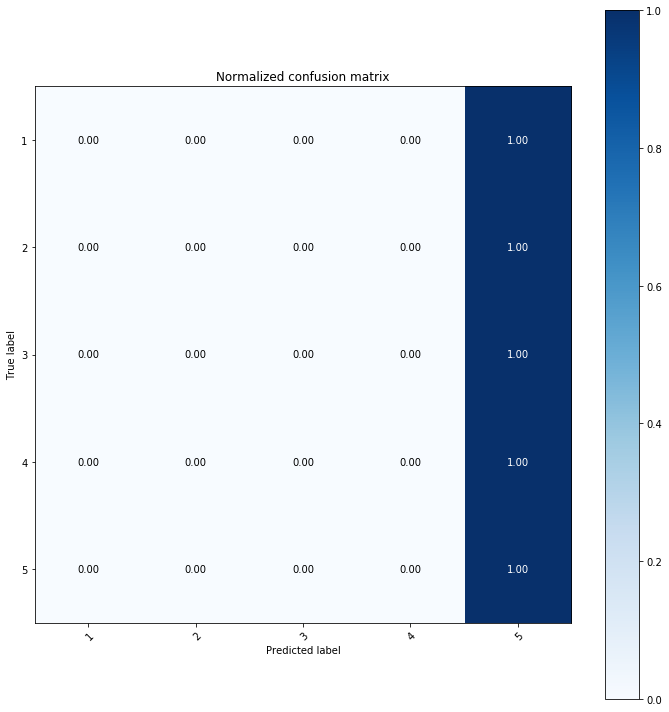

In [32]:
#evaluating it
dc_preds = dc.predict(X_test)
dc_acc = accuracy_score(y_test, dc_preds)
print(classification_report(y_test,dc_preds))
np.set_printoptions(precision=2)
ax = plot_confusion_matrix(y_test, dc_preds, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.plot()

### First experiment: Decision Trees


In [24]:
#training the model using the training data
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

              precision    recall  f1-score   support

           1       0.09      0.07      0.08       175
           2       0.14      0.11      0.12       327
           3       0.24      0.23      0.23       566
           4       0.25      0.25      0.25      1007
           5       0.68      0.71      0.70      2623

    accuracy                           0.49      4698
   macro avg       0.28      0.28      0.28      4698
weighted avg       0.48      0.49      0.48      4698



[]

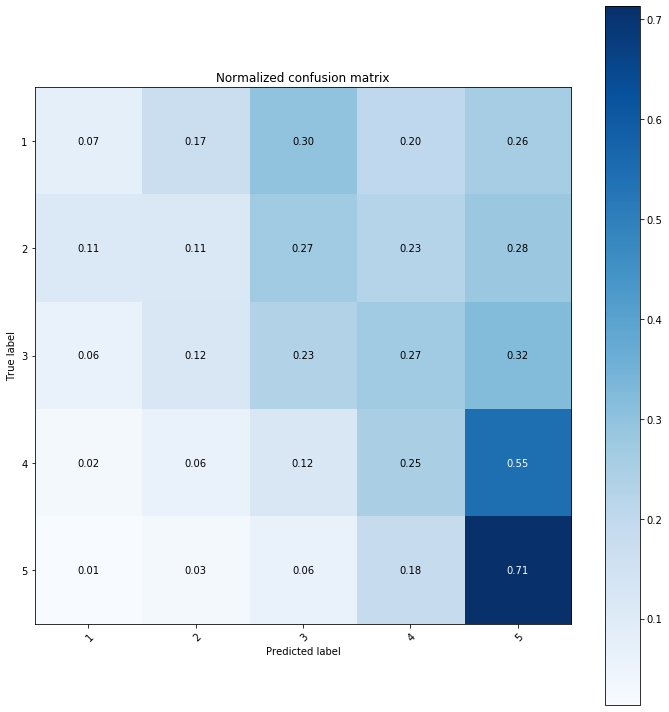

In [25]:
#testing the model using the test data
dt_preds = dt.predict(X_test)
dt_acc = accuracy_score(y_test, dt_preds)
print(classification_report(y_test,dt_preds))
np.set_printoptions(precision=2)
ax = plot_confusion_matrix(y_test, dt_preds, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.plot()

In [26]:
#print some samples of the data and compare predicted and true values
i = 5
print(raw_test[i])
print("Predicted value by Decision Trees: %d" % dt_preds[i])
print("True value: %d" % y_test[i])

I knew i needed to buy this trench from the moment i saw it on my computer screen, but something prompted me to stop by my local retailer and try it on first. thank goodness for that.

at first glance, i knew i wouldn't be buying this. the construction leaves much to be desired. from the flimsy, single layer of unlined, unstructured fabric, to the thin strip of fabric serving as a belt, i could easily see this being sold at a cheap store for teenage girls where throwaway clothes are a dim
Predicted value by Decision Trees: 5
True value: 1


### Second experiment: Logistic Regression

Accuracy for C=0.01: 0.6354443853113358
Accuracy for C=0.05: 0.6458222458754657
Accuracy for C=0.25: 0.6428951569984034
Accuracy for C=0.5: 0.6381053751995742
Accuracy for C=1: 0.6311868014901544
*** Best accuracy = 0.645822, best C = 0.050000


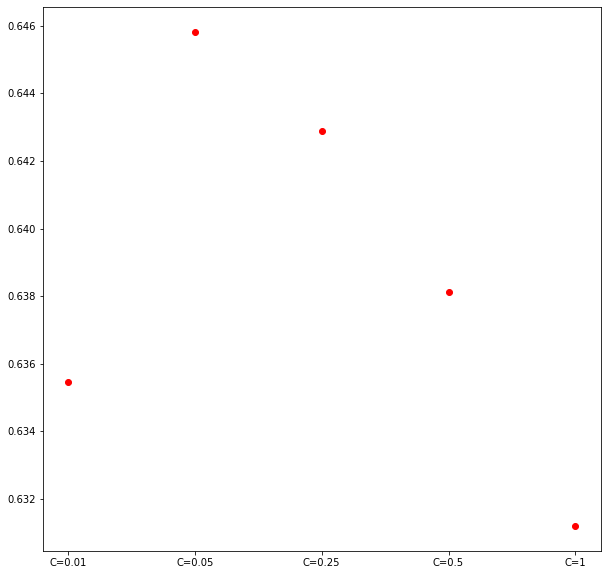

In [38]:
#optimise the parameter C using the validation data
best_acc = 0.
best_c = 0.
accuracies = []
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c, multi_class='auto', solver='liblinear')
    lr.fit(X_train, y_train)
    cur_acc = accuracy_score(y_val, lr.predict(X_val))
    print ("Accuracy for C=%s: %s" % (c, cur_acc))
    accuracies.append(cur_acc)
    if cur_acc > best_acc:
        best_c = c
        best_acc = cur_acc

print ("*** Best accuracy = %f, best C = %f" % (best_acc, best_c))

plt.plot(['C=0.01', 'C=0.05', 'C=0.25', 'C=0.5', 'C=1'], accuracies, 'ro', )

In [28]:
#training the model with the best C
lr = LogisticRegression(C=best_c, multi_class='auto', solver='liblinear')
lr.fit(X_train, y_train)

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

           1       0.56      0.14      0.22       175
           2       0.37      0.12      0.18       327
           3       0.38      0.33      0.36       566
           4       0.44      0.28      0.35      1007
           5       0.72      0.93      0.81      2623

    accuracy                           0.64      4698
   macro avg       0.49      0.36      0.38      4698
weighted avg       0.59      0.64      0.59      4698



[]

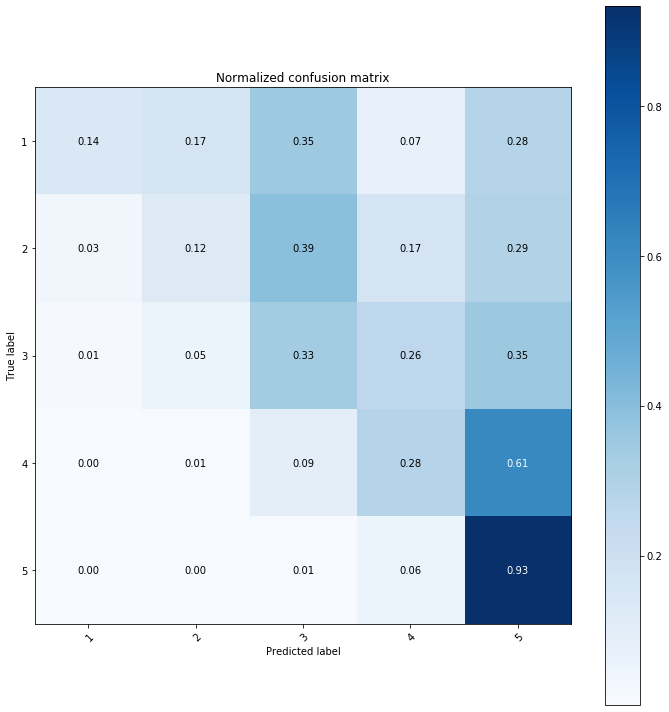

In [29]:
#testing the model and evaluating it
lr_preds = lr.predict(X_test)
print(classification_report(y_test,lr_preds))
np.set_printoptions(precision=2)
plot_confusion_matrix(y_test, lr_preds, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.plot()